# 211016 Basic Plots

In [1]:
from pathlib import Path

In [2]:
import numpy as np
import pandas as pd
import xarray as xr
import h5py as h5
from tqdm import tqdm

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## Setup

In [4]:
DATESTR = '211016'
NBNAME = DATESTR + '-basic-plots'

In [5]:
infiles = dict(
    genomes=Path('data-processed/211015-combine-data/211015-gambit-ani-genomes.csv'),
    data=Path('data-intermediate/211015-combine-data/data.nc'),
    assembly_stats=Path('data-processed/211016-additional-genome-stats/211016-assembly-stats.csv'),
)

## Code

In [7]:
def get_datasets(group):
    return {name: child[:] for name, child in group.items()}

## Load data

### Genomes

In [8]:
genomes = pd.read_csv(infiles['genomes'], index_col=[0, 1])

In [9]:
_stats = pd.read_csv(infiles['assembly_stats'], index_col=[0, 1])
genomes = pd.concat([genomes, _stats], axis=1)

### Common

In [10]:
common_ds = xr.load_dataset(infiles['data'], group='common')

common_df = common_ds.to_dataframe(['data_set', 'param'])

In [11]:
gsets = common_ds.indexes['data_set']
ngsets = len(gsets)

### Params

In [12]:
params_df = common_ds \
    .drop_dims('data_set') \
    .to_dataframe() \
    .set_index(['prefix_len', 'prefix_version', 'k'], drop=True)

In [13]:
def get_param(prefix_len, prefix_version, k):
    return params_df.index.get_loc((prefix_len, prefix_version, k))

In [14]:
gambitdb_param = get_param(5, 0, 11)

### By genome

In [15]:
genome_dss = {gset: xr.load_dataset(infiles['data'], group='genome/' + gset) for gset in gsets}

## ?

In [20]:
ds = genome_dss['konstantinidis_2005']

In [49]:
common_ds['mean_kmer_count'] = xr.concat(
    [ds['kmer_count'].mean(dim='genome') for ds in genome_dss.values()],
    'data_set',
)

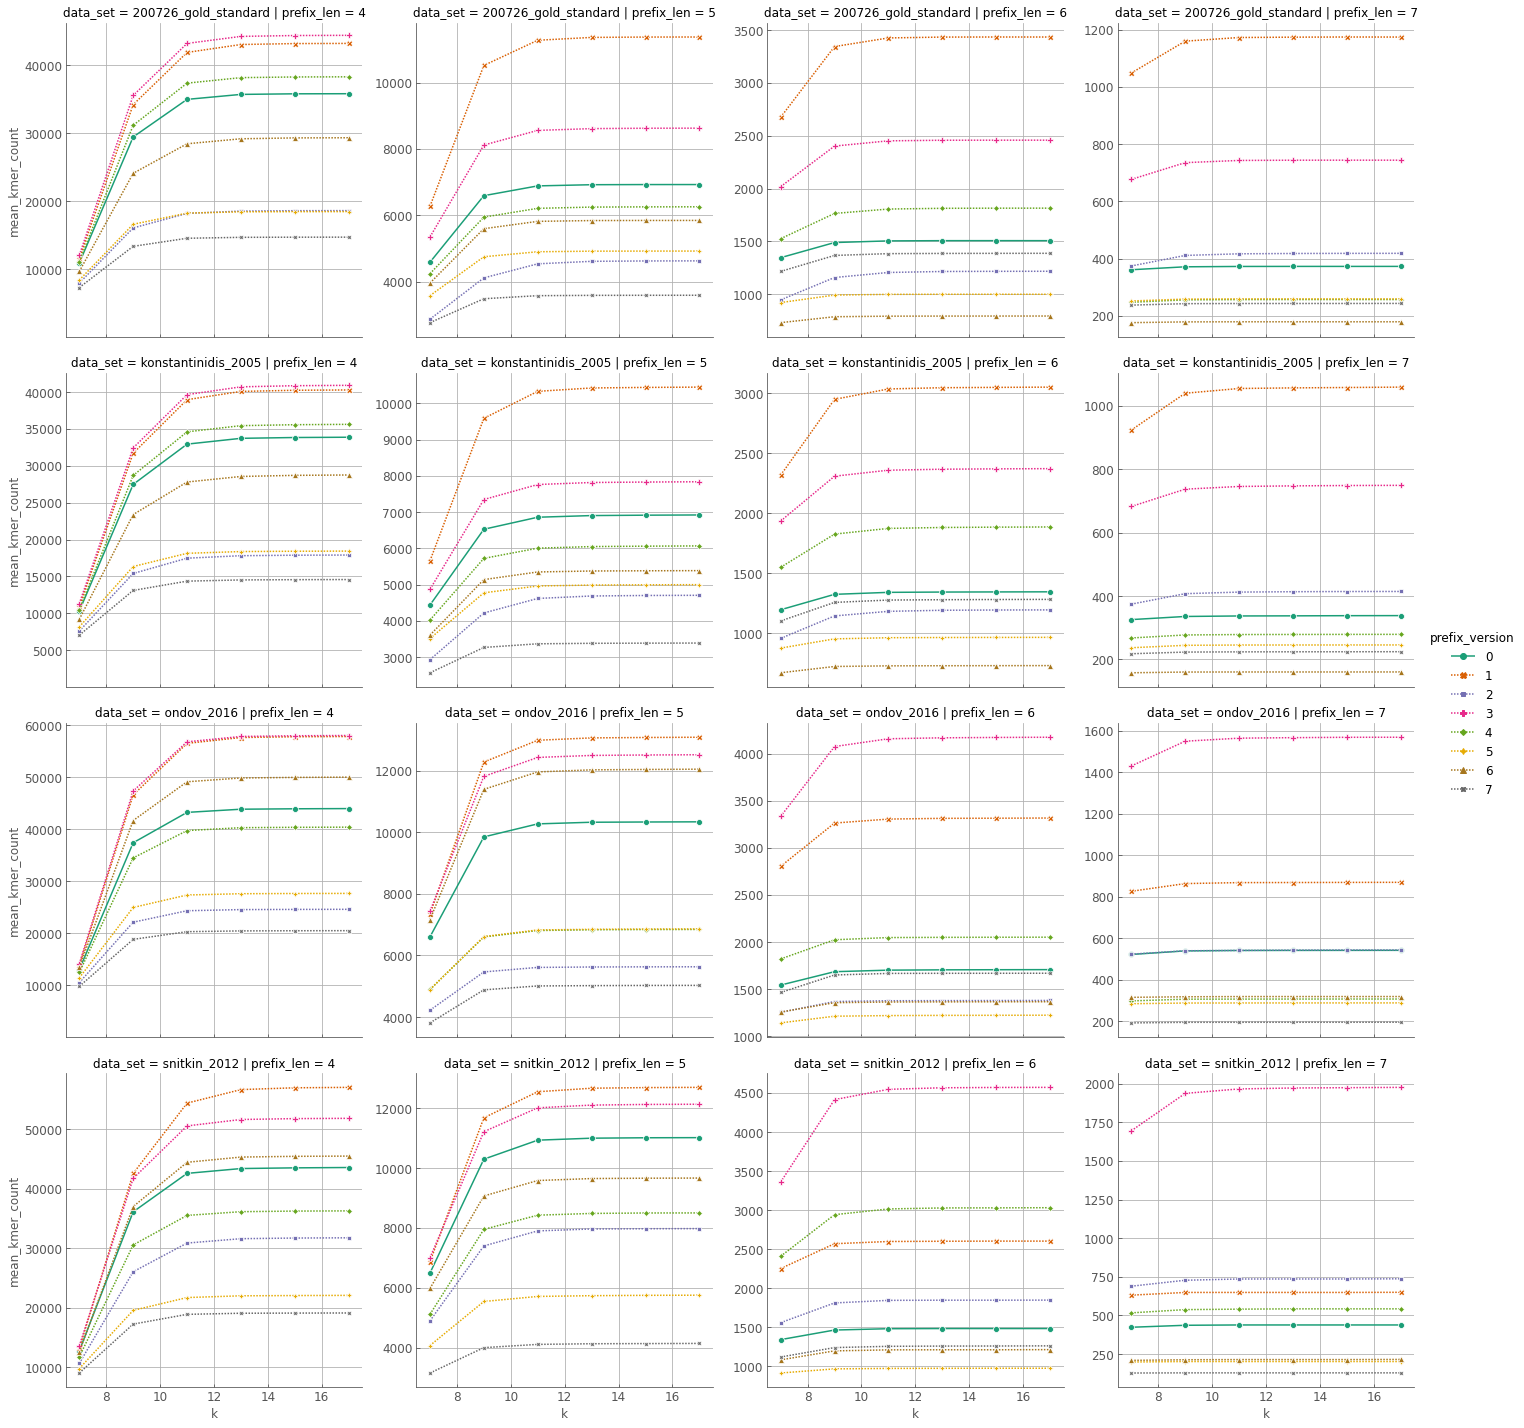

In [54]:
fg = sns.relplot(
    kind='line',
    data=common_ds.to_dataframe().reset_index(),
    x='k',
    y='mean_kmer_count',
    col='prefix_len',
    row='data_set',
    hue='prefix_version',
    style='prefix_version',
    dashes=dict(enumerate([(1, 0)] + [(1, 1)] * 7)),
    markers=True,
    facet_kws=dict(sharey=False),
    palette='Dark2',
    height=5,
)


fg.axes_dict['200726_gold_standard', 4].set_ylim([.8, None])
fg.axes_dict['ondov_2016', 4].set_ylim([.95, None])
fg.axes_dict['konstantinidis_2005', 4].set_ylim([.85, None])
        
plt.savefig(outfiles['gambit_ani_spearman'])

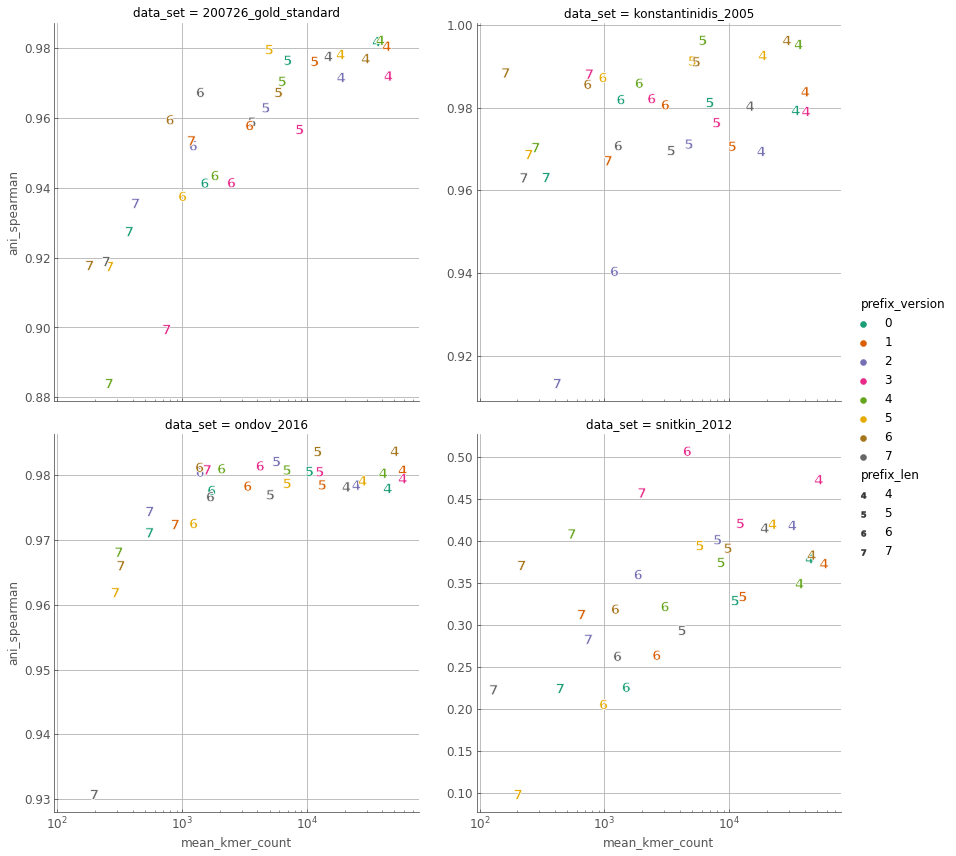

In [88]:
_df = common_ds.to_dataframe().reset_index()
_df = _df[_df['k'] == 17]

fg = sns.relplot(
    kind='scatter',
    data=_df,
    x='mean_kmer_count',
    y='ani_spearman',
    col='data_set',
    col_wrap=2,
    hue='prefix_version',
    style='prefix_len',
    markers=[r'$\mathbf{%d}$' % i for i in range(4, 8)],
    facet_kws=dict(sharey=False),
    palette='Dark2',
    height=6,
    s=100,
    alpha=1.,
)

for ax in fg.axes.flat:
    ax.set_xscale('log')